In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import umap
from sklearn.cluster import AgglomerativeClustering
from collections import Counter
from sklearn import metrics
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import adjusted_rand_score, silhouette_score, mean_squared_error
from models.cluster.HierarchicalModel import HierarchicalModel
import warnings
warnings.filterwarnings("ignore")

In [70]:
X_train = pd.read_csv('data/umist_cropped.csv')

In [71]:
X_train.head(5)

pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
0    234.0    234.0    234.0    234.0    234.0    234.0    234.0    234.0   
1    234.0    234.0    234.0    234.0    234.0    234.0    234.0    234.0   
2    234.0    234.0    234.0    234.0    234.0    234.0    234.0    233.0   
3    234.0    234.0    234.0    234.0    233.0    230.0    225.0    109.0   
4    234.0    234.0    234.0    234.0    234.0    234.0    234.0    234.0   

   pixel_8  pixel_9  ...  pixel_10294  pixel_10295  pixel_10296  pixel_10297  \
0    234.0    233.0  ...        195.0        195.0        193.0        192.0   
1    234.0    234.0  ...        192.0        192.0        191.0        186.0   
2    225.0    186.0  ...        192.0        192.0        191.0        185.0   
3     85.0     84.0  ...        180.0        174.0        168.0        164.0   
4    234.0    234.0  ...        192.0        192.0        191.0        190.0   

   pixel_10298  pixel_10299  pixel_10300  pixel_10301  pixel_10302  \
0        192.0        192.0        192.0        191.0        190.0   
1        183.0        179.0        174.0        169.0        165.0   
2        184.0        177.0        170.0        166.0        164.0   
3        157.0        152.0        151.0        148.0        145.0   
4        188.0        184.0        177.0        173.0        168.0   

   pixel_10303  
0        191.0  
1        164.0  
2        163.0  
3        145.0  
4        164.0  

[5 rows x 10304 columns]

In [72]:
X_train.shape

(600, 10304)

In [73]:
X_train = X_train.to_numpy()

In [74]:
# 1. Preprocess the Data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
X_scaled

array([[9.77937596e-01, 9.91074847e-01, 9.91092970e-01, ...,
        8.79185122e-01, 8.73521205e-01, 8.78653648e-01],
       [9.77937596e-01, 9.91074847e-01, 9.91092970e-01, ...,
        7.68438150e-01, 7.47042410e-01, 7.42139003e-01],
       [9.77937596e-01, 9.91074847e-01, 9.91092970e-01, ...,
        7.53336290e-01, 7.41983259e-01, 7.37082905e-01],
       ...,
       [5.48521868e-05, 3.07863526e-04, 5.59110309e-04, ...,
        3.45586075e-01, 3.42310267e-01, 3.42707262e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.60485689e-01, 3.47369419e-01, 3.47763360e-01],
       [2.12060911e-02, 2.42945046e-02, 2.70870474e-02, ...,
        3.13761583e-01, 3.09032464e-01, 3.04843503e-01]])

In [75]:
# 2. Apply PCA to Retain 99.5% Variance
pca = PCA(n_components=0.995)
X_pca = pca.fit_transform(X_scaled)
print(f"Number of components chosen by PCA: {X_pca.shape[1]}")

Number of components chosen by PCA: 422


In [76]:
# 3. Apply UMAP on the PCA-Reduced Data
umap_reducer = umap.UMAP(n_components=X_pca.shape[1], random_state=123)
X_umap = umap_reducer.fit_transform(X_pca)
X_umap

array([[0.18429592, 4.9479127 , 7.0390277 , ..., 4.8995805 , 5.0677967 ,
        4.374133  ],
       [0.23959857, 5.0978265 , 7.1760964 , ..., 4.893129  , 5.060391  ,
        4.370631  ],
       [0.26691797, 5.087511  , 7.163623  , ..., 4.8954196 , 5.060898  ,
        4.3733683 ],
       ...,
       [7.443632  , 1.7707694 , 4.258899  , ..., 4.98816   , 5.12756   ,
        4.4874053 ],
       [7.5230713 , 1.8502811 , 4.322945  , ..., 4.985202  , 5.1238317 ,
        4.485533  ],
       [7.5414143 , 1.8453771 , 4.3167934 , ..., 4.9856443 , 5.1253743 ,
        4.487318  ]], dtype=float32)

In [77]:
errors = []
for n in range(2, 21):  # Test components from 2 to 20
    # Reduce data
    reducer = umap.UMAP(n_components=n, random_state=123)
    reduced_data = reducer.fit_transform(X_pca)
    
    # Reconstruct data
    reconstructor = umap.UMAP(n_components=X_pca.shape[1], random_state=123)
    reconstructed_data = reconstructor.fit_transform(reduced_data)
    
    # Compute error
    mse = mean_squared_error(X_pca, reconstructed_data)
    errors.append((n, mse))

In [78]:
# Print results
least_error = 100
least_error_component = 0
for n, mse in errors:
    if least_error > mse:
        least_error = mse
        least_error_component = n
    print(f"Components: {n}, Reconstruction Error: {mse}")

Components: 2, Reconstruction Error: 27.22781857728402
Components: 3, Reconstruction Error: 27.59083541362816
Components: 4, Reconstruction Error: 26.42102036274039
Components: 5, Reconstruction Error: 27.185785484902564
Components: 6, Reconstruction Error: 26.819305935768124
Components: 7, Reconstruction Error: 27.559184348092238
Components: 8, Reconstruction Error: 26.44965148845505
Components: 9, Reconstruction Error: 27.78770416609215
Components: 10, Reconstruction Error: 27.196501959819745
Components: 11, Reconstruction Error: 27.086358113160344
Components: 12, Reconstruction Error: 27.12572699728569
Components: 13, Reconstruction Error: 26.56083587357284
Components: 14, Reconstruction Error: 26.065247518590592
Components: 15, Reconstruction Error: 26.51609783376456
Components: 16, Reconstruction Error: 27.322933296189465
Components: 17, Reconstruction Error: 26.449293866082005
Components: 18, Reconstruction Error: 27.493251455088227
Components: 19, Reconstruction Error: 26.445877

In [79]:
print(f"The least error Components: {least_error_component}")

The least error Components: 14


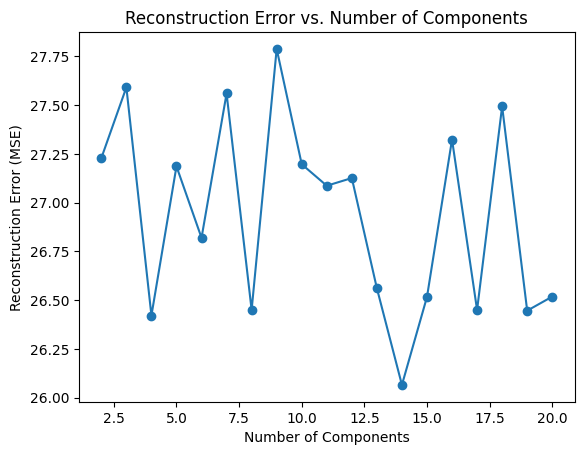

In [80]:
# Extract values for plotting
components = [n for n, _ in errors]
mse_values = [mse for _, mse in errors]

# Plot the reconstruction error
plt.plot(components, mse_values, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Reconstruction Error vs. Number of Components')
plt.show()

In [81]:
# Apply final the best number of component for UMAP on the PCA-Reduced Data
umap_reducer = umap.UMAP(n_components=least_error_component, random_state=123)
X_umap = umap_reducer.fit_transform(X_pca)
X_umap

array([[1.5893948, 5.5619383, 7.695084 , ..., 6.3139586, 4.496843 ,
        4.317913 ],
       [1.6393579, 5.434282 , 7.82112  , ..., 6.3930693, 4.411044 ,
        4.3285894],
       [1.6490026, 5.4541287, 7.797085 , ..., 6.3760943, 4.4301043,
        4.3303504],
       ...,
       [7.7649717, 9.087299 , 3.8305643, ..., 3.8899448, 7.071352 ,
        2.9174347],
       [7.8335376, 8.981926 , 3.9016116, ..., 3.916605 , 7.0540967,
        2.9939456],
       [7.843277 , 8.99251  , 3.8892505, ..., 3.9137902, 7.0602827,
        2.958136 ]], dtype=float32)

In [82]:
# Initialize Agglomerative Clustering
expected_cluster = 20
agg_cluster = AgglomerativeClustering(n_clusters=expected_cluster, metric='euclidean', linkage='ward')
# Fit the model and predict cluster labels
cluster_labels = agg_cluster.fit_predict(X_umap)
agg_cluster_labels = cluster_labels

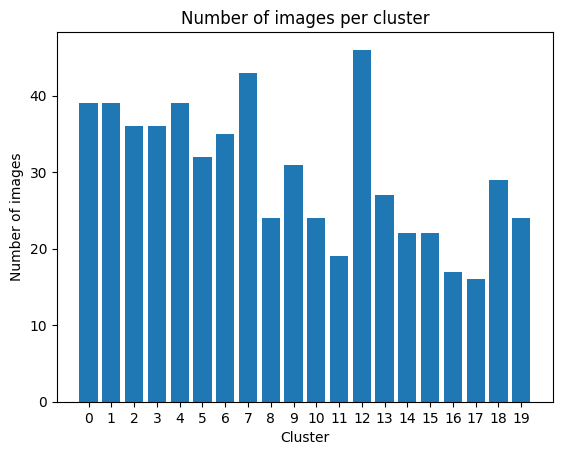

In [83]:
plt.bar(range(expected_cluster), np.bincount(cluster_labels))
plt.xlabel('Cluster')
plt.ylabel('Number of images')
plt.title('Number of images per cluster')
plt.xticks(range(expected_cluster))
plt.show()

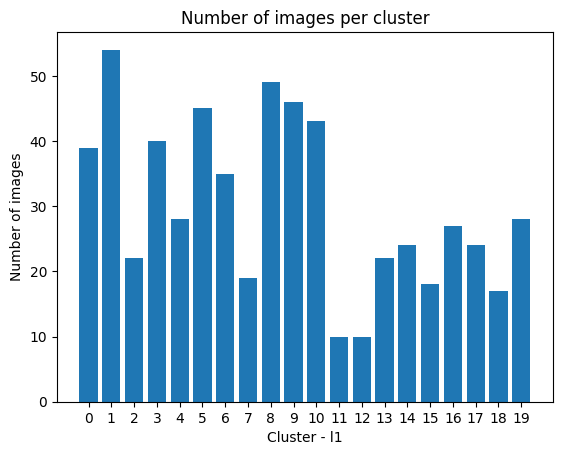

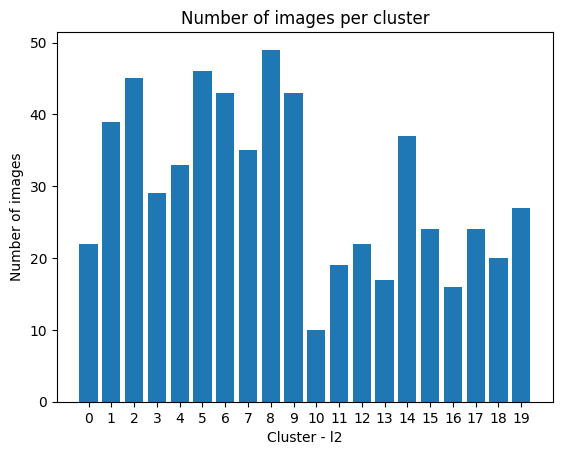

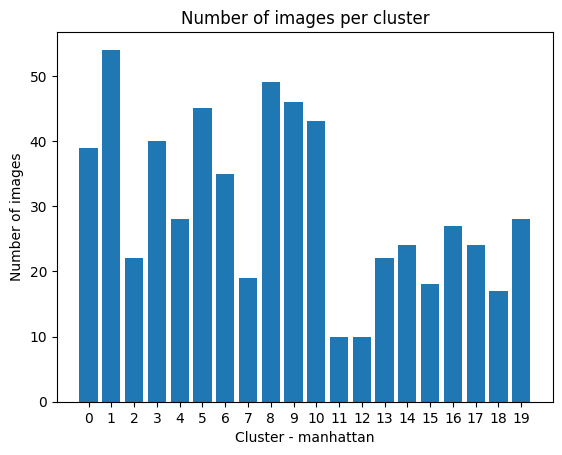

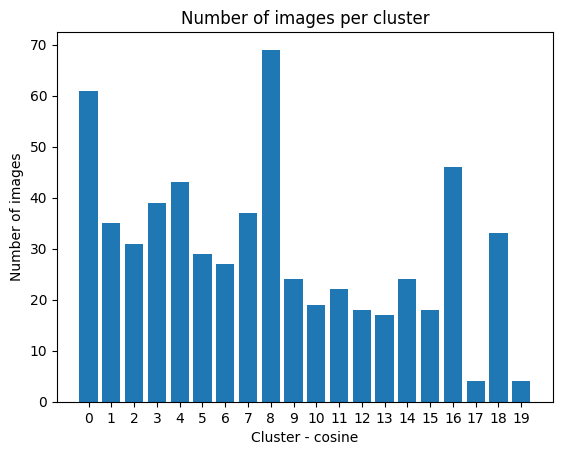

In [84]:
metrics = ['l1', 'l2', 'manhattan', 'cosine']
expected_cluster = 20

for met in metrics:
    agg_cluster = AgglomerativeClustering(n_clusters=expected_cluster, metric=met, linkage='average')
    
    # Fit the model and predict cluster labels
    cluster_labels = agg_cluster.fit_predict(X_umap)

    plt.bar(range(expected_cluster), np.bincount(cluster_labels))
    plt.xlabel(f'Cluster - {met}')
    plt.ylabel('Number of images')
    plt.title('Number of images per cluster')
    plt.xticks(range(expected_cluster))
    plt.show() 

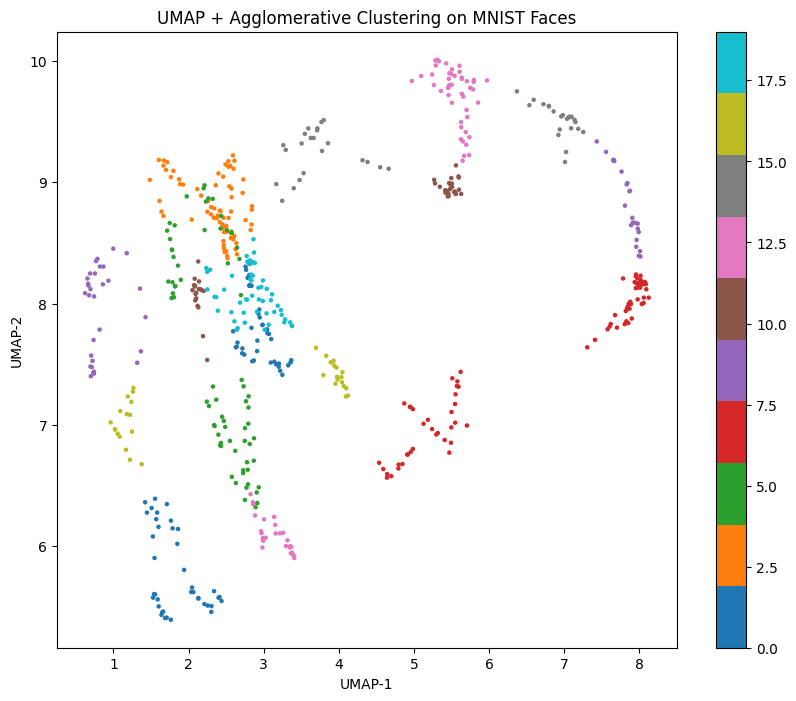

In [85]:
plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=agg_cluster_labels, cmap='tab10', s=5)
plt.colorbar()
plt.title("UMAP + Agglomerative Clustering on MNIST Faces")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

In [86]:
# Measure the quality of clustering (higher is better for silhouette score)
silhouette = silhouette_score(X_umap, agg_cluster_labels)
print(f"Silhouette Score: {silhouette:.2f}")

Silhouette Score: 0.46


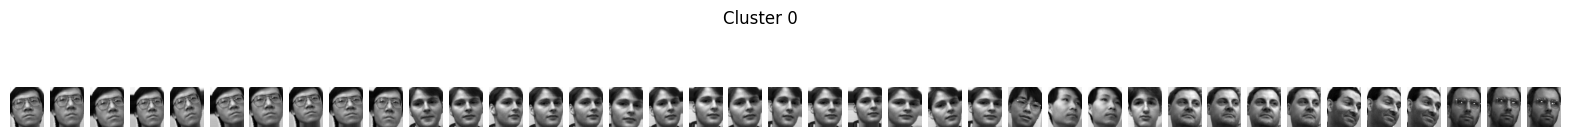

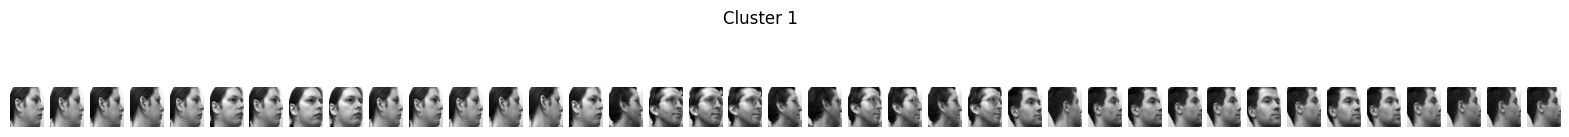

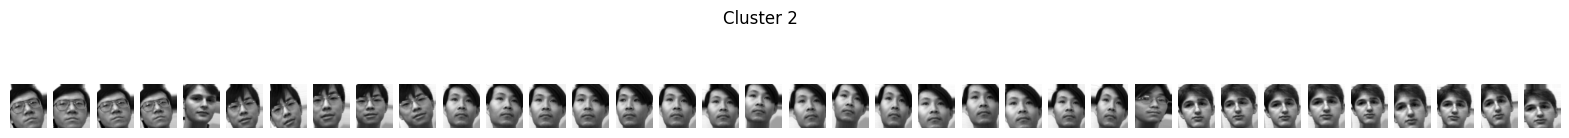

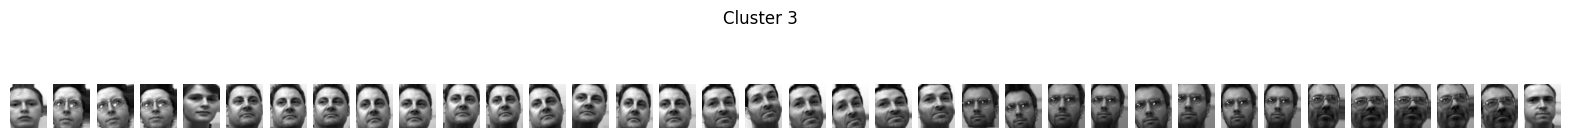

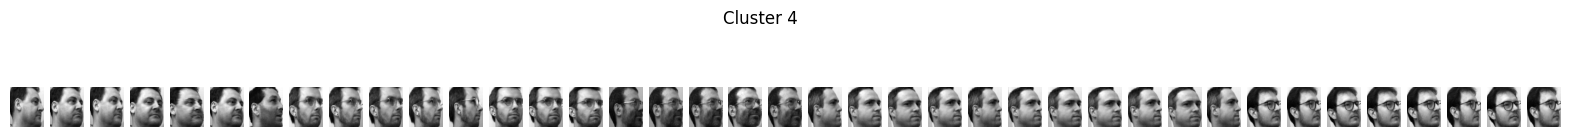

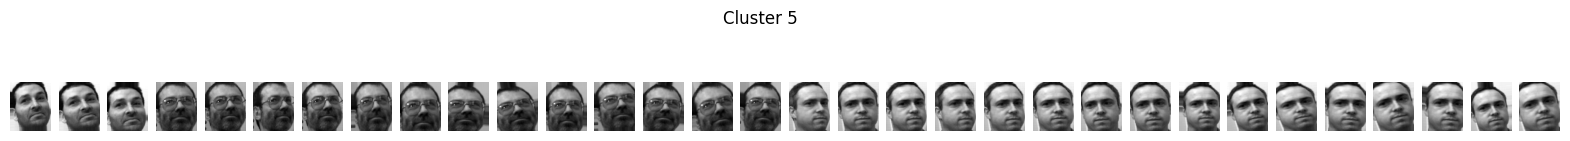

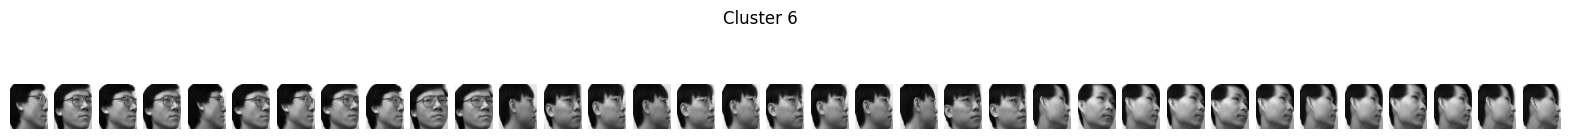

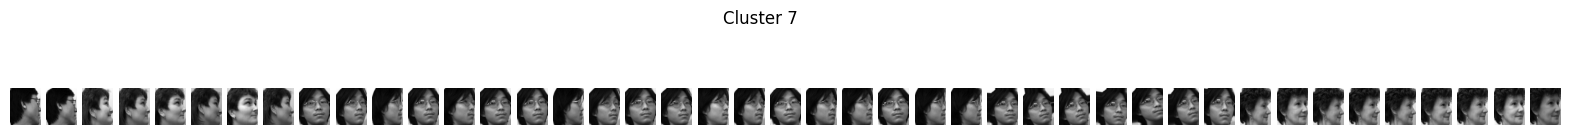

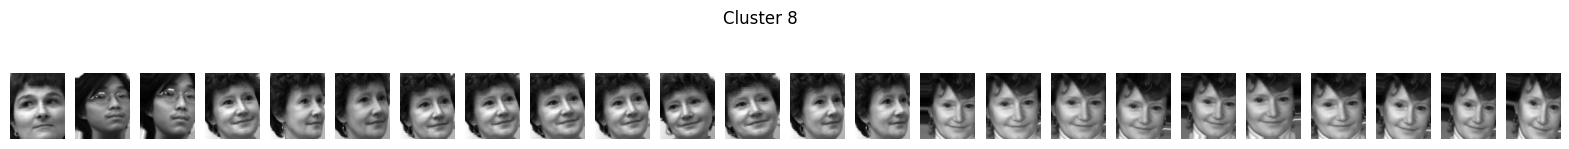

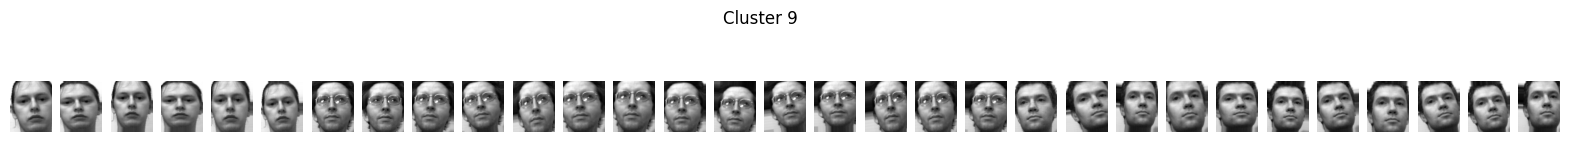

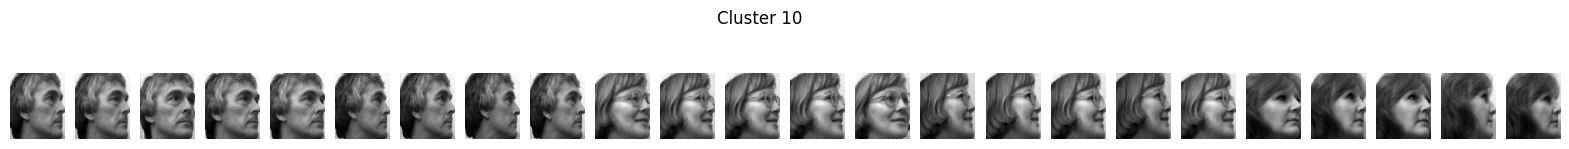

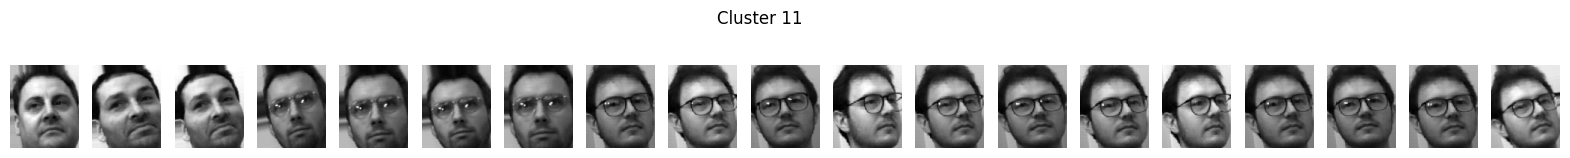

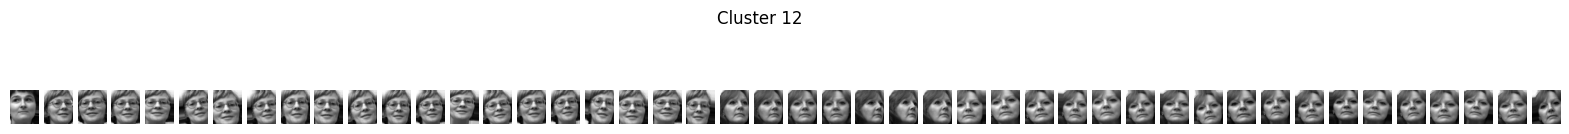

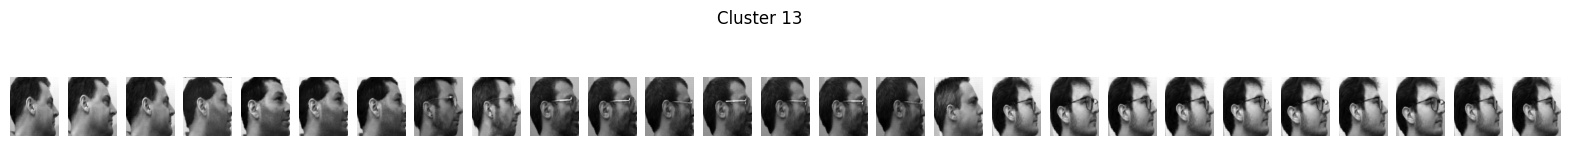

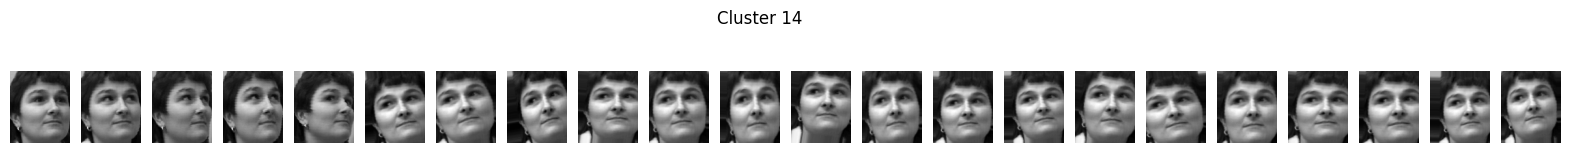

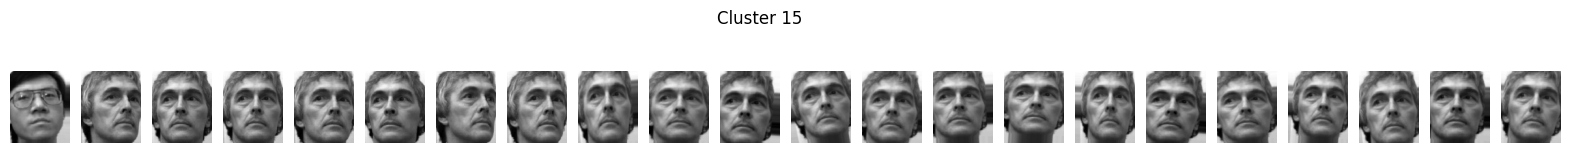

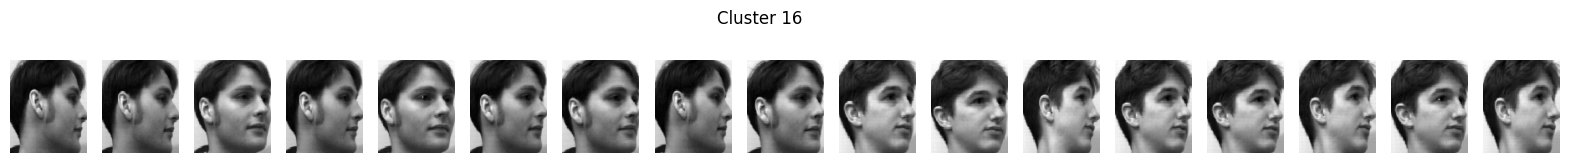

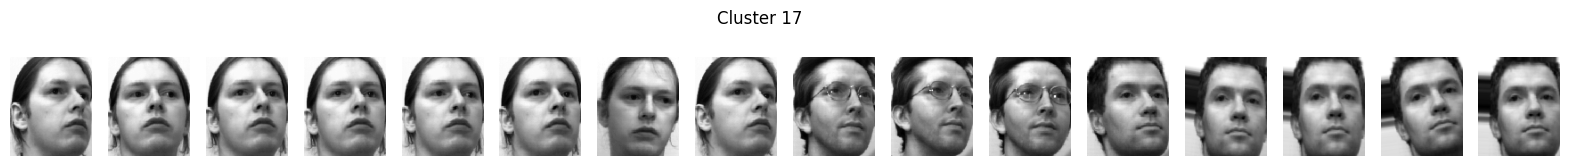

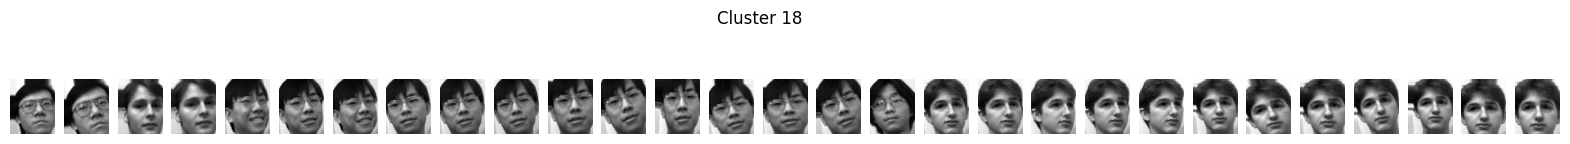

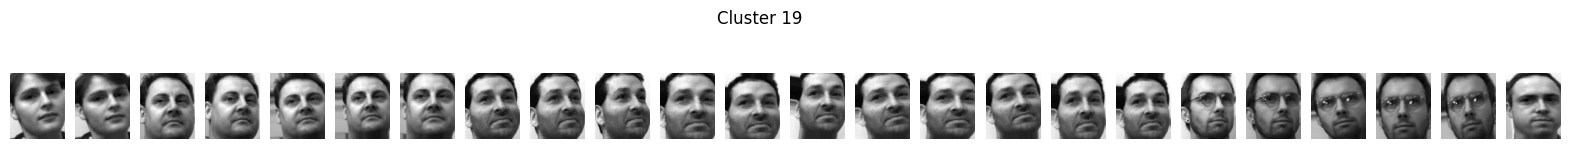

In [87]:
def plot_result(cluster_labels, cluster_num):
    for cluster_id in range(cluster_num+1):
        # Get the indices of images in the current cluster
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        
        # Determine the number of images to plot
        num_images = len(cluster_indices)
        
        if num_images > 0:
            fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
            
            # Handle the case where there is only one image
            if num_images == 1:
                axes = [axes]  # Convert single axis to a list for consistency
            
            for i in range(num_images):
                # Get the image index
                image_index = cluster_indices[i]
                
                # Get the image data
                image_data = X_train[image_index]
                
                # Reshape the image data
                image_data = image_data.reshape(112, 92)
                
                # Plot the image
                axes[i].imshow(image_data, cmap='gray')
                axes[i].axis('off')
            
            plt.suptitle(f"Cluster {cluster_id}")
            plt.show()
plot_result(agg_cluster_labels, expected_cluster)

Average linkage and euclidean metric: 

Number of clusters: 20
Silhouette Score: 0.4769531786441803


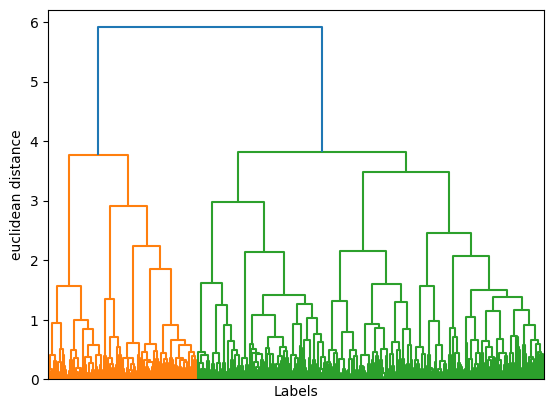

Average linkage and minkowski metric: 

Number of clusters: 20
Silhouette Score: 0.459602131234276


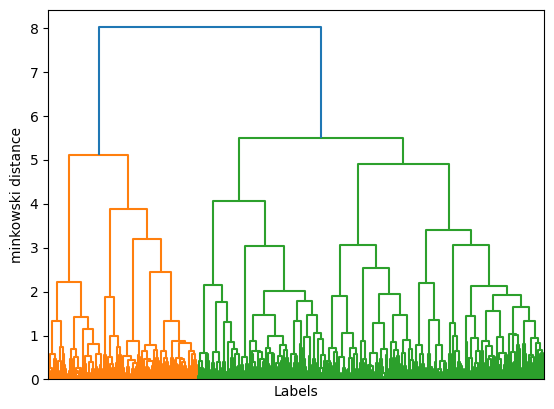

Average linkage and cosine metric: 

Number of clusters: 20
Silhouette Score: 0.6084125638008118


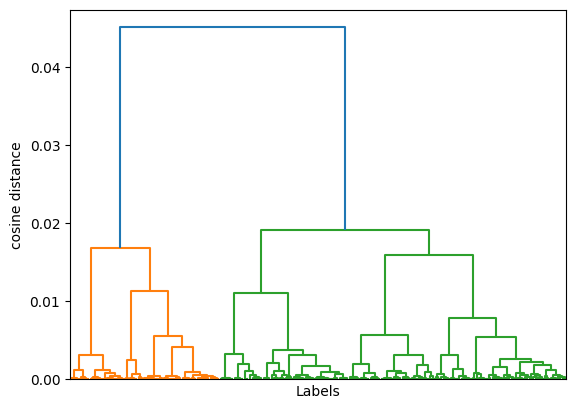

Average linkage and cityblock metric: 

Number of clusters: 20
Silhouette Score: 0.46980636429702166


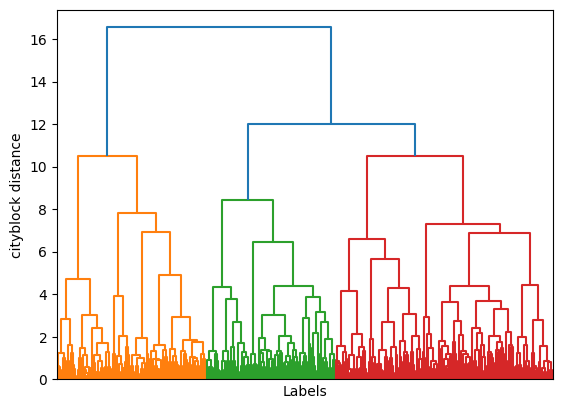

In [88]:
metrics_list = ['euclidean', 'minkowski', 'cosine', 'cityblock']       
                
results = {}
square_distances_matrix = []
clusters_res = []

for m in metrics_list:
    print(f'Average linkage and {m} metric: \n')
    
    if m == 'minkowski':
        Y = pdist(X_umap, metric=m, p=1.5)
    else:
        Y = pdist(X_umap, metric=m)
        
    Z = linkage(Y, method='average')
    clusters = fcluster(Z, 20, criterion='maxclust')
    dendrogram(Z, no_labels= True)
    # Check the number of clusters
    num_clusters = len(set(clusters))
    clusters_res.append(clusters)
    print(f'Number of clusters: {num_clusters}')
    silhouette = silhouette_score(X_umap, clusters, metric=m)
    print(f'Silhouette Score: {silhouette}')
    plt.xlabel("Labels")
    plt.ylabel(f'{m} distance')
    plt.show()

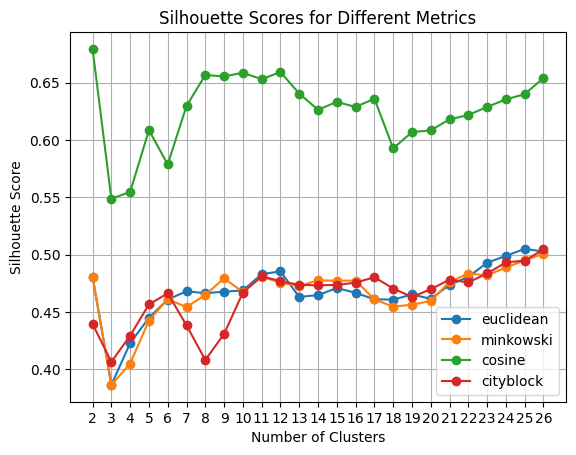

In [89]:
max_clusters = 26  # Maximum number of clusters to test
for metric in metrics_list:
    silhouette_scores = []
    
    # Iterate through the possible number of clusters
    for n_clusters in range(2, max_clusters + 1):  # Start from 2 clusters
        # Compute pairwise distances
        if metric == 'minkowski':
            Y = pdist(X_umap, metric=metric, p=1.5)
        else:
            Y = pdist(X_umap, metric=metric)
        
        if metric in ['euclidean']:
            Z = linkage(Y, method='ward')
        else:
            Z = linkage(Y, method='average')

        # Create flat clusters
        clusters = fcluster(Z, n_clusters, criterion='maxclust')

        # Check the number of clusters formed
        num_clusters_formed = len(set(clusters))
        
        # Ensure that the number of clusters is valid
        if num_clusters_formed > 1:
            # Calculate silhouette score
            silhouette = silhouette_score(X_umap, clusters, metric=metric)
            silhouette_scores.append(silhouette)
        else:
            silhouette_scores.append(-1)  # Append a negative score or None if not valid

    # Store results for the current metric
    results[metric] = silhouette_scores

    # Plotting
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', label=metric)

# Plotting
plt.title("Silhouette Scores for Different Metrics")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.xticks(range(2, max_clusters + 1))
plt.legend()
plt.grid()
plt.show()

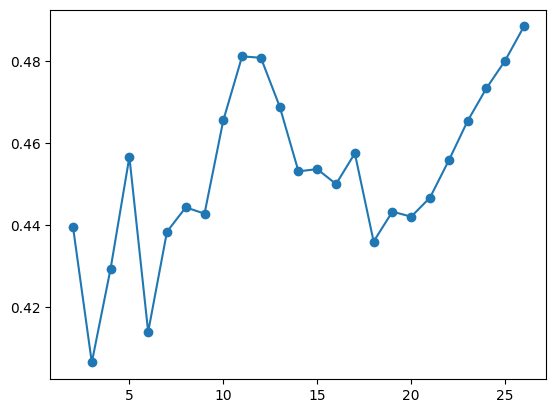

In [90]:
silhouette_scores = []
best_cluster_num = 1
best_score = 0

for n_clusters in range(2, max_clusters + 1):  # Start from 2 clusters
    Y = pdist(X_umap, metric='cosine')
    Z = linkage(Y, method='average')
    clusters = fcluster(Z, n_clusters, criterion='maxclust')
    num_clusters_formed = len(set(clusters))
    if num_clusters_formed > 1:
        silhouette = silhouette_score(X_umap, clusters, metric=metric)
        silhouette_scores.append(silhouette)
        if silhouette > best_score:
            best_score = silhouette
            best_cluster_num = num_clusters_formed
    else:
        silhouette_scores.append(-1)  # Append a negative score or None if not valid
# Plotting
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', label=metric)
plt.show()

In [91]:
print(f'The best cluster number: {best_cluster_num} with score {best_score}')

The best cluster number: 26 with score 0.4884358931124024


Using user-defined model

In [92]:
model = HierarchicalModel(best_cluster_num, 'average', 'cosine')
cluster_labels = model.fit_predict(X_umap)

In [93]:
print("Cluster labels for each image:", Counter(cluster_labels))

Cluster labels for each image: Counter({14: 69, 7: 46, 2: 43, 17: 37, 23: 33, 21: 27, 26: 26, 16: 25, 5: 24, 1: 24, 10: 23, 6: 22, 12: 21, 22: 19, 20: 18, 24: 18, 4: 18, 8: 17, 25: 17, 18: 15, 15: 14, 19: 14, 9: 12, 11: 10, 3: 4, 13: 4})


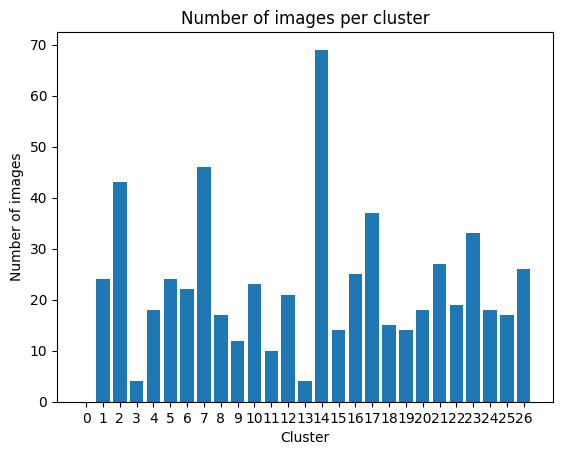

In [94]:
plt.bar(range(best_cluster_num +1), np.bincount(cluster_labels))
plt.xlabel('Cluster')
plt.ylabel('Number of images')
plt.title('Number of images per cluster')
plt.xticks(range(best_cluster_num+1))
plt.show()

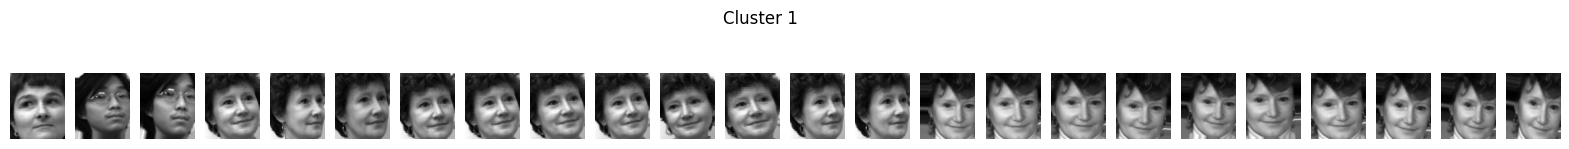

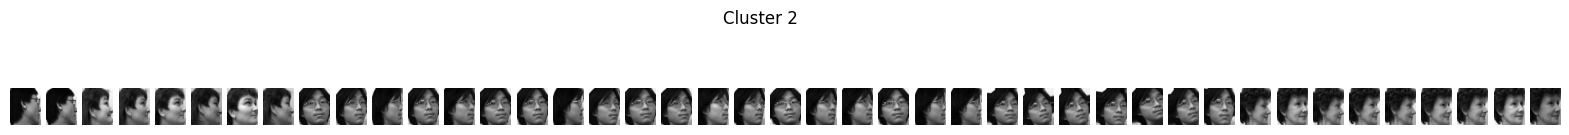

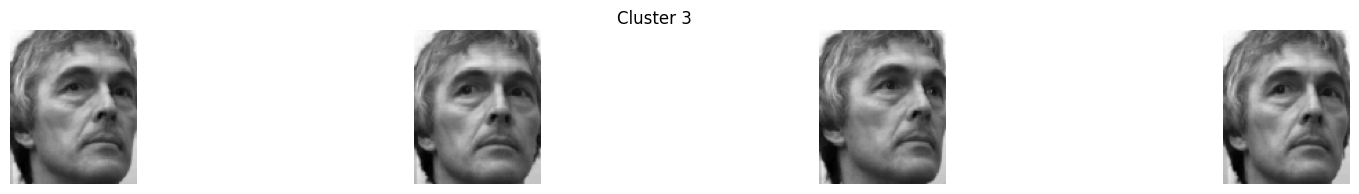

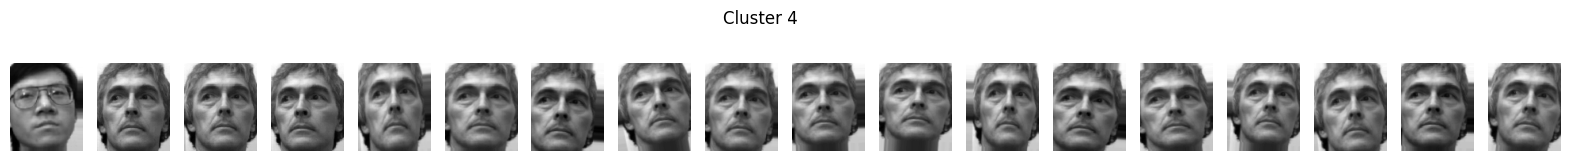

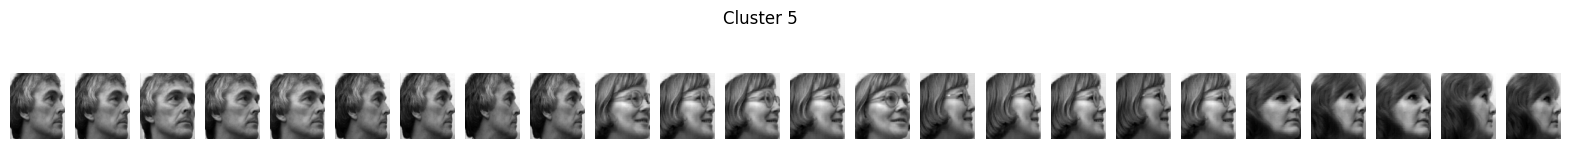

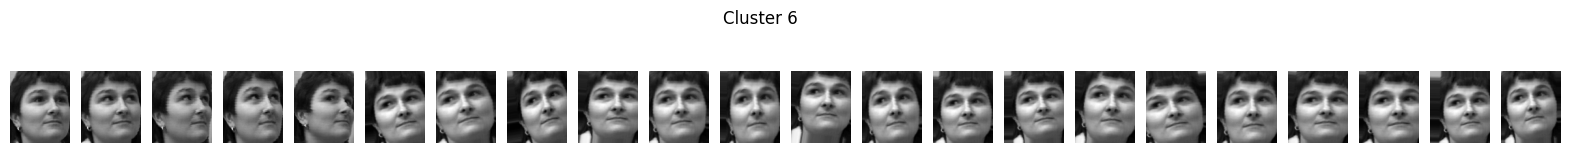

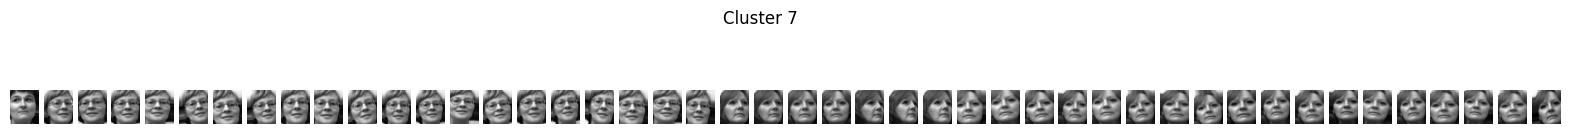

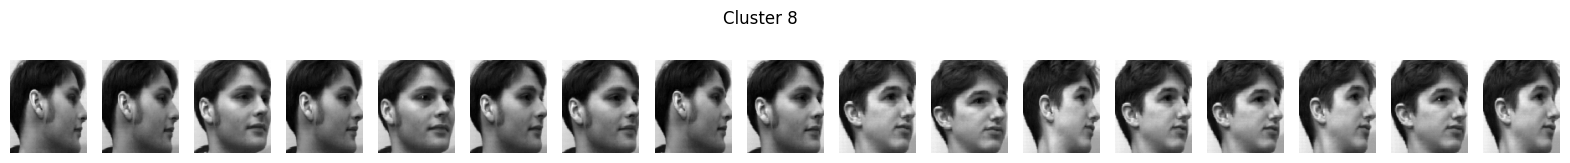

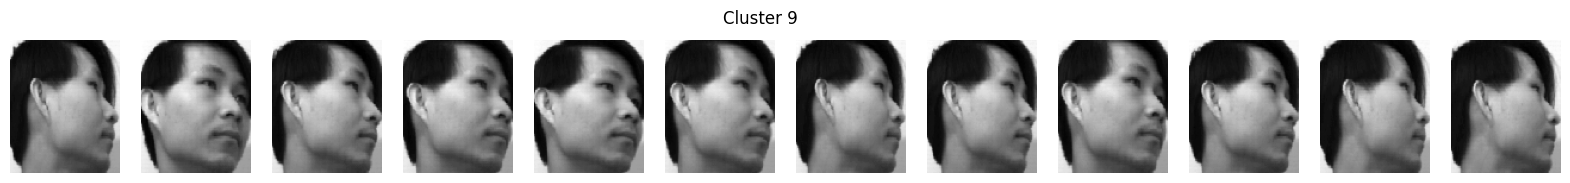

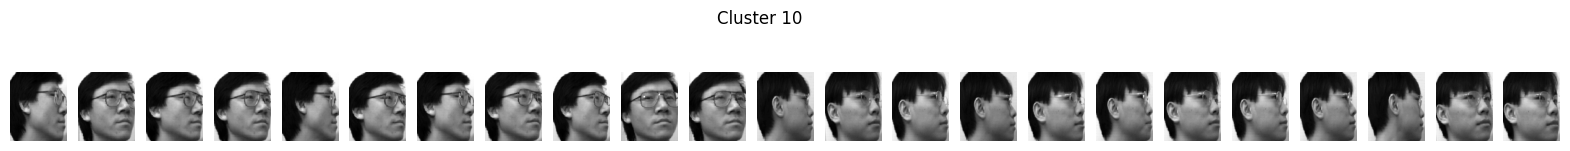

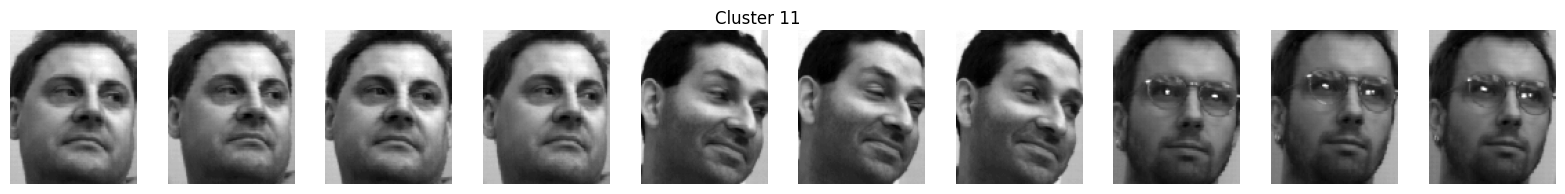

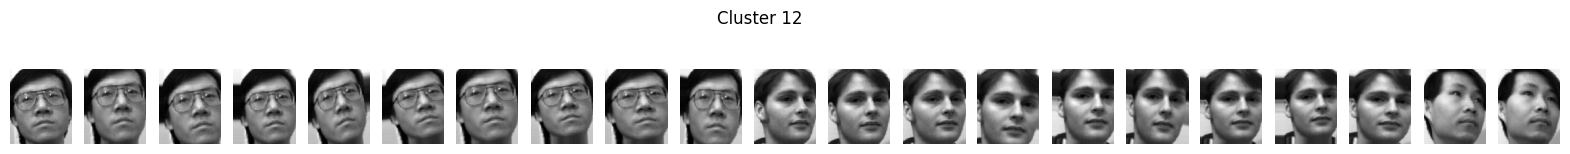

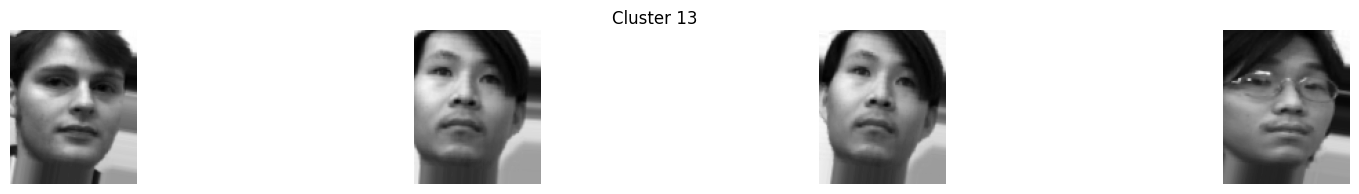

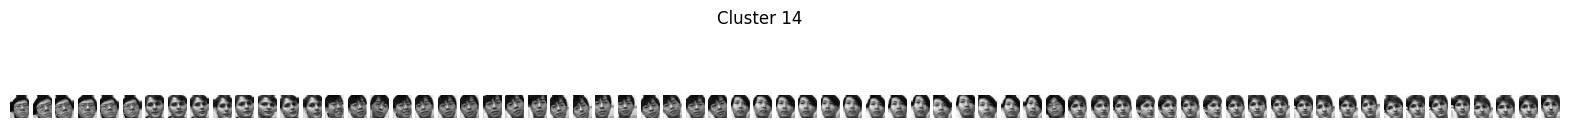

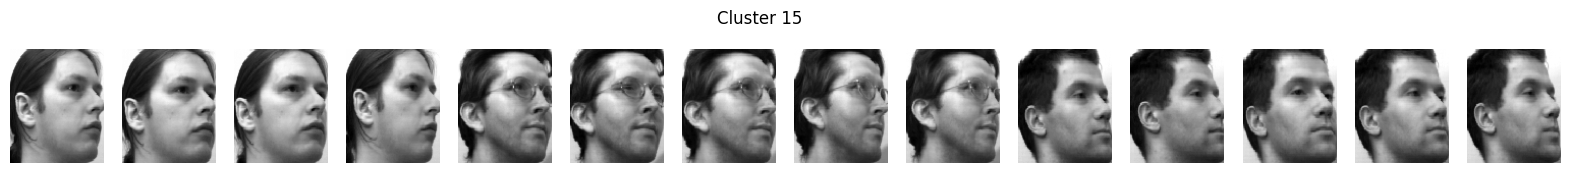

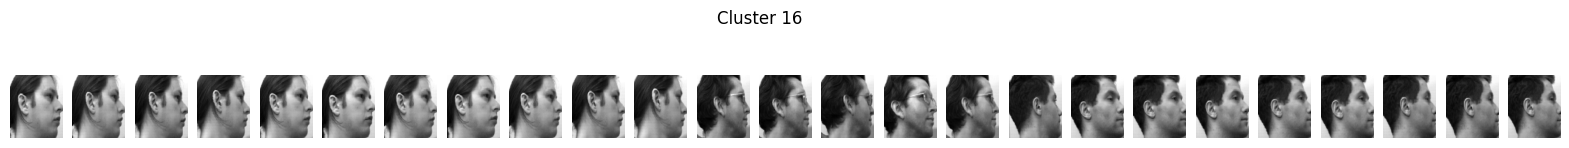

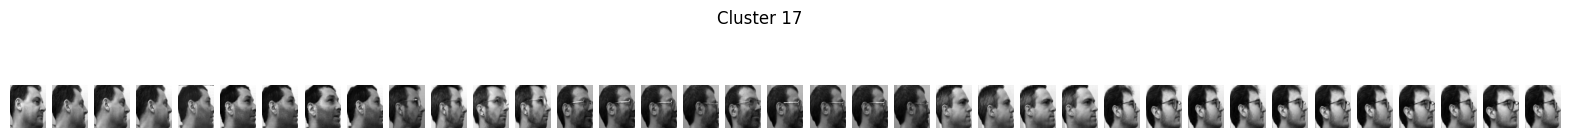

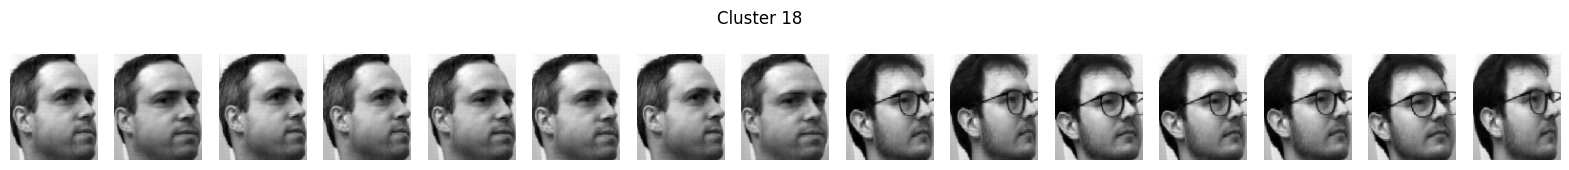

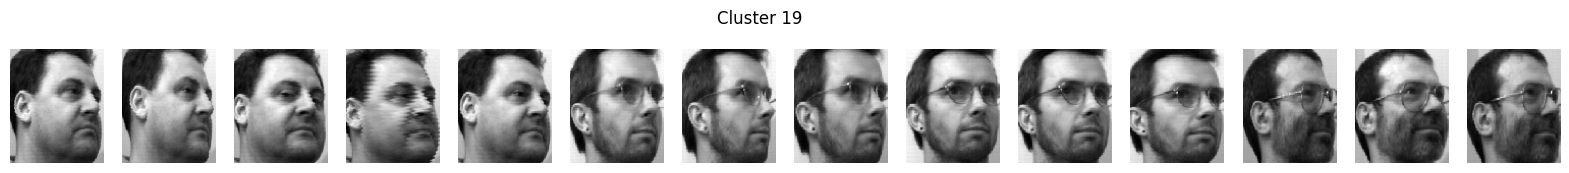

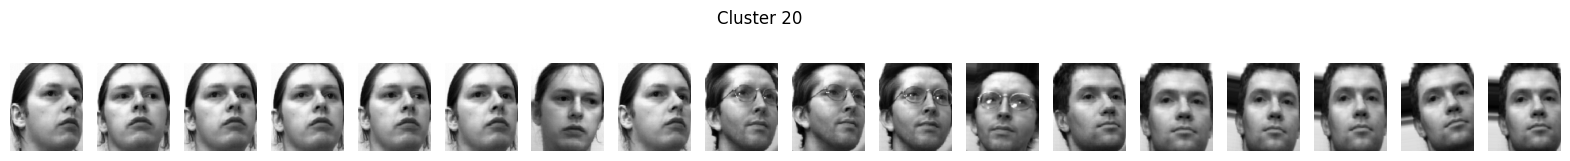

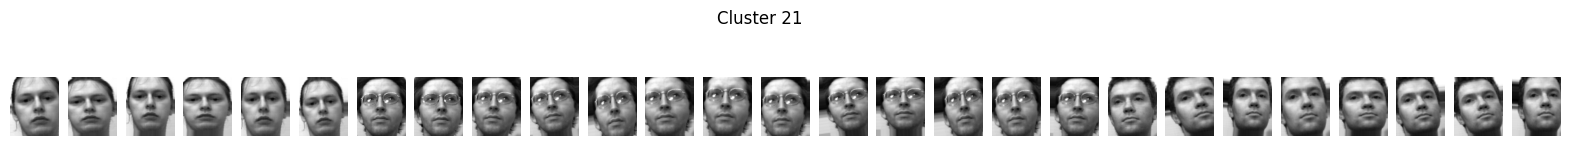

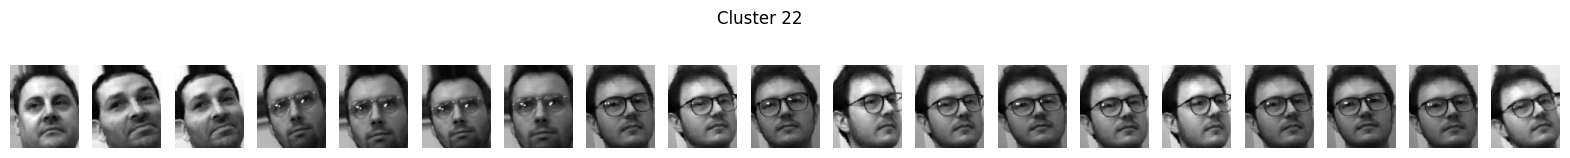

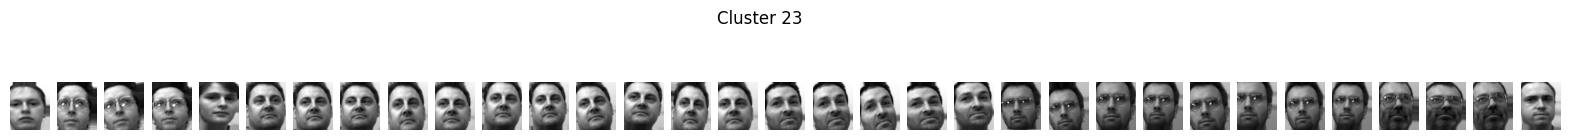

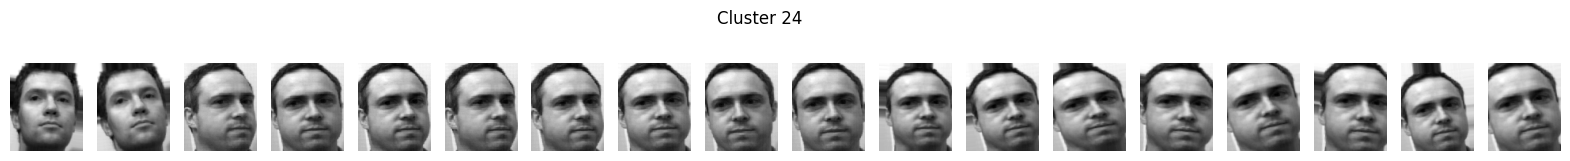

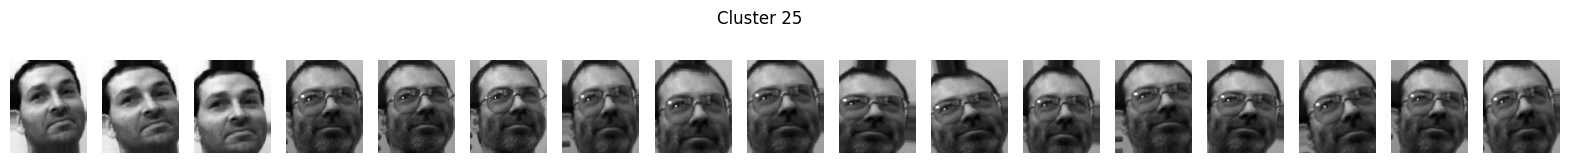

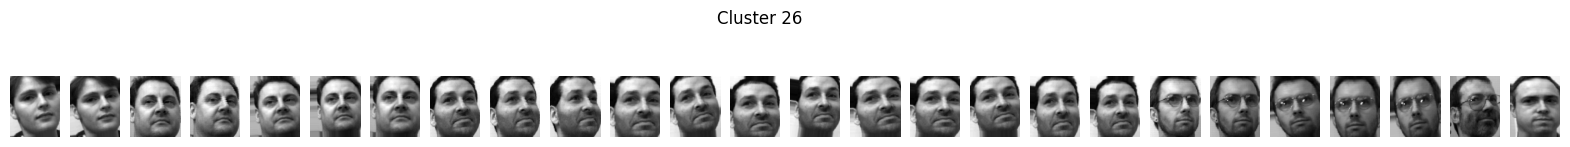

In [95]:
plot_result(cluster_labels, best_cluster_num)

In [96]:
original_data = pd.read_csv("data/umist_with_original_face_id.csv")

In [97]:
original_data['cluster_id'] = cluster_labels

In [98]:
original_labels = original_data['label']
clustered_labels = original_data['cluster_id']

In [99]:
unique_labels = np.unique(original_labels)
unique_clustered_labels = np.unique(clustered_labels)

original_labels = original_labels.to_numpy()
clustered_labels = clustered_labels.to_numpy()

In [100]:
def autopct_format(pct):
    return f'{pct:.1f}%' if pct >= 10 else ''

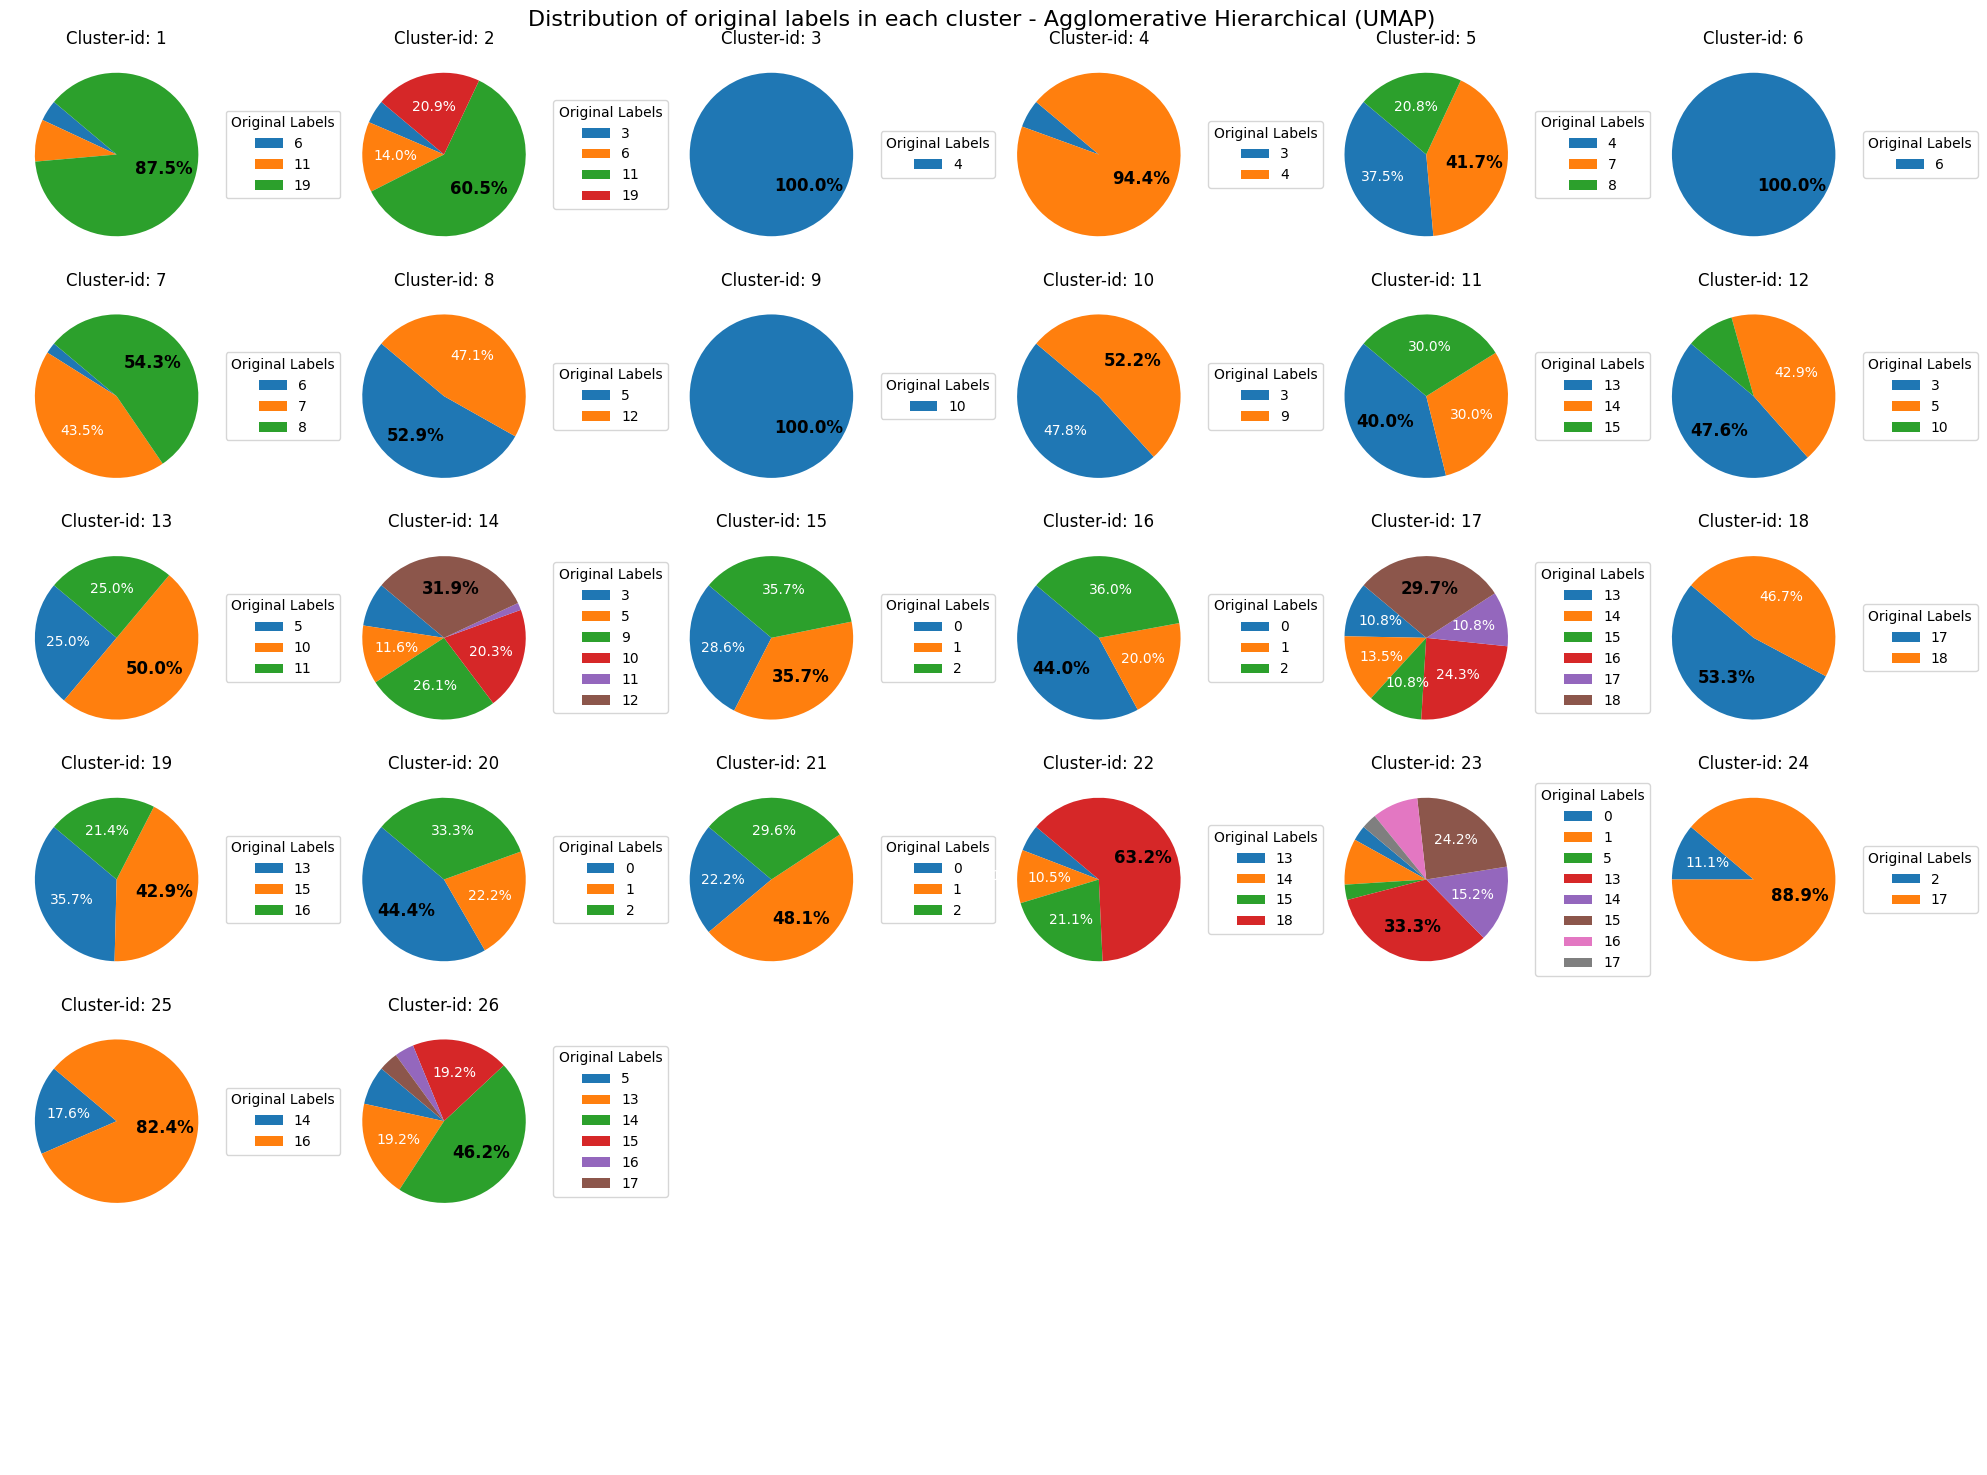

In [101]:
import math

df = pd.DataFrame({'Original Labels': original_labels, 'Clustered Labels': clustered_labels})

# Calculate grid dimensions
num_clusters = len(unique_clustered_labels)
grid_size = math.ceil(math.sqrt(num_clusters))  # Determine size of the grid (square root for square layout)

fig, axes = plt.subplots(grid_size, grid_size, figsize=(20, 15), subplot_kw=dict(aspect="equal"))
axes = axes.flatten()

for i, cluster in enumerate(unique_clustered_labels):
    cluster_data = df[df['Clustered Labels'] == cluster]
    cluster_original_labels = cluster_data['Original Labels']
    
    cluster_original_labels_count = Counter(cluster_original_labels)
    labels = list(cluster_original_labels_count.keys())
    counts = list(cluster_original_labels_count.values())
    
    wedges, texts, autotexts = axes[i].pie(
        counts,
        labels=labels,
        autopct=lambda pct: autopct_format(pct),
        textprops=dict(color="w"),
        startangle=140
    )
    
    axes[i].legend(wedges, labels, title='Original Labels', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))
    
    # Highlight the largest percentage
    largest_pct_idx = np.argmax(counts)
    autotexts[largest_pct_idx].set_color('black')
    autotexts[largest_pct_idx].set_fontsize(12)
    autotexts[largest_pct_idx].set_fontweight('bold')
        
    axes[i].set_title(f'Cluster-id: {cluster}')
        
# Turn off unused subplots
for j in range(num_clusters, len(axes)):
    axes[j].axis('off')

plt.suptitle('Distribution of original labels in each cluster - Agglomerative Hierarchical (UMAP)', fontsize=16)
plt.tight_layout()
plt.show()


In [102]:
# Store the results for further sorting
majority_labels = []

# Extract majority label details for each cluster
for cluster in unique_clustered_labels:
    # Filter data belonging to the current cluster
    cluster_data = df[df['Clustered Labels'] == cluster]
    
    # Get the original labels for the cluster using the DataFrame indices
    cluster_orig_labels = original_labels[cluster_data.index]
    
    # Count the occurrences of each original label
    composition = Counter(cluster_orig_labels)
    
    # Find the majority label
    majority_label, count = composition.most_common(1)[0]
    total = sum(composition.values())
    percentage = (count / total) * 100
    
    # Append the cluster, majority label, count, and percentage
    majority_labels.append((cluster, majority_label, count, percentage))

# Separate clusters based on the percentage
high_majority = [x for x in majority_labels if x[3] > 50]
low_majority = [x for x in majority_labels if x[3] <= 50]

# Sort high_majority by cluster ID
high_majority.sort(key=lambda x: x[0])

# Sort low_majority by majority label (true label)
low_majority.sort(key=lambda x: x[1])

# Print sorted results
print("\nClusters with majority percentage > 50% (sorted by cluster ID):")
for cluster, majority_label, count, percentage in high_majority:
    print(f"Cluster {cluster}: Majority label {majority_label} with {count} images ({percentage:.1f}%)")

print("\nClusters with majority percentage <= 50% (sorted by true label):")
for cluster, majority_label, count, percentage in low_majority:
    print(f"Cluster {cluster}: Majority label {majority_label} with {count} images ({percentage:.1f}%)")


Clusters with majority percentage > 50% (sorted by cluster ID):
Cluster 1: Majority label 19 with 21 images (87.5%)
Cluster 2: Majority label 11 with 26 images (60.5%)
Cluster 3: Majority label 4 with 4 images (100.0%)
Cluster 4: Majority label 4 with 17 images (94.4%)
Cluster 6: Majority label 6 with 22 images (100.0%)
Cluster 7: Majority label 8 with 25 images (54.3%)
Cluster 8: Majority label 5 with 9 images (52.9%)
Cluster 9: Majority label 10 with 12 images (100.0%)
Cluster 10: Majority label 9 with 12 images (52.2%)
Cluster 18: Majority label 17 with 8 images (53.3%)
Cluster 22: Majority label 18 with 12 images (63.2%)
Cluster 24: Majority label 17 with 16 images (88.9%)
Cluster 25: Majority label 16 with 14 images (82.4%)

Clusters with majority percentage <= 50% (sorted by true label):
Cluster 16: Majority label 0 with 11 images (44.0%)
Cluster 20: Majority label 0 with 8 images (44.4%)
Cluster 15: Majority label 1 with 5 images (35.7%)
Cluster 21: Majority label 1 with 13 ima

In [103]:
umist_cropped_training = pd.read_csv("data/umist_cropped.csv")

umist_cropped_training['cluster_id'] = cluster_labels

umist_cropped_training.to_csv("data/umist_cropped_with_cluster_id_training.csv", index=False)

In [105]:
umist_cropped_val = pd.read_csv("data/validation_data/umist_val.csv")

X_val = umist_cropped_val.to_numpy()

In [108]:
X_val_scaled = scaler.transform(X_val)
X_val_pca = pca.transform(X_val_scaled)
X_val_umap = umap_reducer.transform(X_val_pca)

In [109]:
cluster_labels_val = model.predict(X_val_umap)

In [110]:
umist_cropped_val['cluster_id'] = cluster_labels_val

umist_cropped_val.to_csv("data/validation_data/umist_cropped_with_cluster_id_val.csv", index=False)